# Getting the Model

First we install the requirements as mentioned in the README.md file.

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Import all the dependencies needed for the predict function.

In [2]:
import pandas as pd
import joblib
from pydantic import BaseModel, Field
from pydantic.tools import parse_obj_as

Create Pydantic models for data validation and modeling.

In [3]:
# Pydantic Models
class Student(BaseModel):
    student_id: str = Field(alias="Student ID")
    gender: str = Field(alias="Gender")
    age: str = Field(alias="Age")
    major: str = Field(alias="Major")
    gpa: str = Field(alias="GPA")
    extra_curricular: str = Field(alias="Extra Curricular")
    num_programming_languages: str = Field(alias="Num Programming Languages")
    num_past_internships: str = Field(alias="Num Past Internships")

    class Config:
        allow_population_by_field_name = True

class PredictionResult(BaseModel):
    good_employee: int

Create the predict function.

In [4]:
# Main Functionality
def predict(student):
    '''
    Returns a prediction on whether the student will be a good employee
    based on given parameters by using the ML model

    Parameters
    ----------
    student : dict
        A dictionary that contains all fields in Student
    
    Returns
    -------
    dict
        A dictionary satisfying type PredictionResult, contains a single field
        'good_employee' which is either 1 (will be a good employee) or 0 (will
        not be a good employee)
    '''
    # Use Pydantic to validate model fields exist
    student = parse_obj_as(Student, student)

    clf = joblib.load('./model.pkl')
    
    student = student.dict(by_alias=True)
    query = pd.DataFrame(student, index=[0])
    prediction = clf.predict(query) # TODO: Error handling ??

    return { 'good_employee': prediction[0] }

All the code above was provided in the draft pull request. Now we will use the sample from the README.md file to make sure it works as intended.

In [5]:
student = {
        "student_id": "student1",
        "major": "Computer Science",
        "age": "20",
        "gender": "M",
        "gpa": "4.0",
        "extra_curricular": "Men's Basketball",
        "num_programming_languages": "1",
        "num_past_internships": "2"
    }

In [6]:
predict(student)

{'good_employee': 1}

It works :) Now we can start evaluating the model.

# Evaluating Model Performance & Fairness

Since we don't know how the model provided in the draft pull request was trained, we want to evaluate it before implementing it into NodeBB. In the rest of the notebook, we will be evaluating the model's performance and fairness.

The engineer who created the model made the following assumptions:
- The model is used to predict whether a student will be a good candidate for a software engineering job.
- It is a binary classifier, where 1 means the student is a good candidate, and 0 means the student is not a good candidate.
- The model is trained on a dataset of students who have graduated from CMU, and have been working in the industry for at least 1 year.
- In order to prevent bias, they assumed that removing Gender (M, F) and Student ID from the dataset would be sufficient when it comes to training the model. They claimed that it is now Group Unaware, thus the model would be fair.

The model specification is as follows:

In [7]:
# X variable (input parameters)
# - Age (18 - 25)
# - Major (Computer Science, Information Systems, Business, Math,
#          Electrical and Computer Engineering, Statistics and Machine Learning)
# - GPA (0 - 4.0)
# - Extra Curricular Activities (Student Theatre, Buggy, Teaching Assistant, Student Government,
#     Society of Women Engineers, Women in CS, Volleyball, Sorority, Men's Basketball,
#     American Football, Men's Golf, Fraternity)
# - Number of Programming Languages (1, 2, 3, 4, 5)
# - Number of Past Internships (0, 1, 2, 3, 4)

# Y variable (output)
# - Good Candidate (0, 1)

A test dataset has been provided to us in the following format:

In [8]:
# X variable
# - Student ID
# - Gender (M, F)
# - Age (18 - 25)
# - Major (Computer Science, Information Systems, Business, Math,
#          Electrical and Computer Engineering, Statistics and Machine Learning)
# - GPA (0 - 4.0)
# - Extra Curricular Activities (Student Theatre, Buggy, Teaching Assistant, Student Government,
#     Society of Women Engineers, Women in CS, Volleyball, Sorority, Men's Basketball,
#     American Football, Men's Golf, Fraternity)
#   # Likely Co-Ed (Student Theatre, Buggy, Teaching Assistant, Student Government)
#   # Likely Majority Female (Society of Women Engineers, Women in CS, Volleyball, Sorority)
#   # Likely Majority Male (Men's Basketball, American Football, Men's Golf, Fraternity)
# - Number of Programming Languages (1, 2, 3, 4, 5)
# - Number of Past Internships (0, 1, 2, 3, 4)

# Y variable
# - Good Candidate (0, 1)

This test dataset is a different set of students from the training dataset, and the evaluation of whether the student is a good candidate is done by a fair panel of recruiters, so it can be considered to be unbiased. Additionally, the panel of recruiters have provided us with additional context on the extracurricular activities in comments (marked with #).

## Preliminary Analysis

Before we evaluate the fairness of the model, we want to do a prelimiary analysis on the test dataset.

### Loading the Model and Test Dataset

The first thing we have to do is load the model and test dataset.

In [9]:
import pandas as pd
import pickle

In [10]:
test_df = pd.read_csv("student_data.csv")
model = pickle.load(open("model.pkl","rb"))

### Plotting the Distributions of the Test Dataset

Now we want to plot the distribution of the test dataset across all features (except Student ID). We will be using the seaborn library.

In [11]:
test_df.head()

,Student ID,Gender,Age,Major,GPA,Extra Curricular,Num Programming Languages,Num Past Internships,Good Candidate
0,0,F,21,Statistics and Machine Learning,2.83,Sorority,4,1,0
1,1,M,20,Information Systems,2.89,Fraternity,5,3,0
2,2,F,20,Math,2.66,Teaching Assistant,3,1,0
3,3,M,20,Information Systems,2.48,Fraternity,5,0,0
4,4,F,21,Statistics and Machine Learning,3.30,Sorority,2,1,0


In [12]:
test_df.describe()

,Student ID,Age,GPA,Num Programming Languages,Num Past Internships,Good Candidate
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,249.500000,20.944000,2.905780,3.04600,2.052000,0.474000
std,144.481833,1.455025,0.839559,1.36073,1.407572,0.499824
min,0.000000,18.000000,0.000000,1.00000,0.000000,0.000000
25%,124.750000,20.000000,2.345000,2.00000,1.000000,0.000000
50%,249.500000,21.000000,2.990000,3.00000,2.000000,0.000000
75%,374.250000,22.000000,3.560000,4.00000,3.000000,1.000000
max,499.000000,25.000000,4.000000,5.00000,4.000000,1.000000


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

Gender (Categorical - M/F)
- Bar chart: Show the count of each gender category using bars.

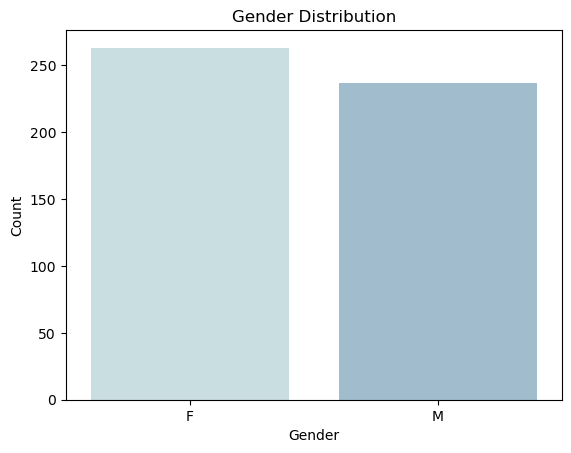

In [49]:
# Group the data by gender and count the occurrences
gender_counts = test_df["Gender"].value_counts()

# Create a bar chart
sns.set_palette(sns.cubehelix_palette(start=.5, rot=-.4))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

Age (Numerical - Integer)
- Histogram: Visualize the distribution of ages using a histogram.

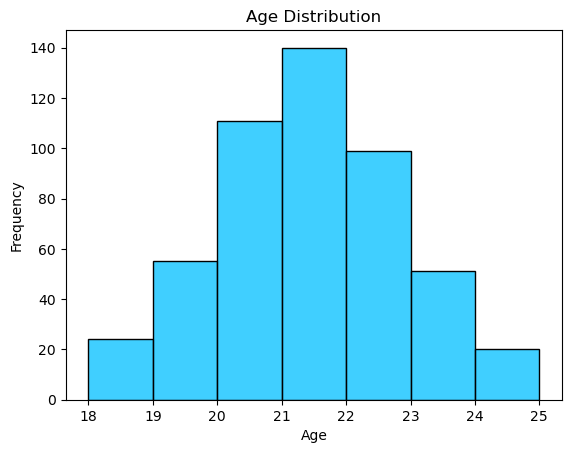

In [65]:
# Create a histogram using Seaborn
sns.histplot(test_df["Age"], bins=7, color="deepskyblue")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution")
plt.show()

Major (Categorical - String)
- Bar chart or count plot: Show the count of each major category.

In [ ]:
# Count the occurrences of each major category
major_counts = test_df["Major"].value_counts()

# Create a barplot using Seaborn
sns.barplot(x=major_counts.values, y=major_counts.index, palette="viridis")

plt.title("Major Distribution")
plt.xlabel("Count")
plt.ylabel("Major")
plt.show()

## Running the Model

Now we will run the model on the test dataset to get the accuracy of the model.

First, we have to predict the output of the test dataset using the model.

In [15]:
# TODO

Now we can report the accuracy of the model along with the confusion matrix.

In [16]:
# TODO

In [17]:
# ⠀⢀⡤⢚⡭⣿⡟⠉⠉⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠁⠉⠁⠀⠀⠀⠉⠉⠁⠀⠉⣿⠀⠀⠀⠀⠀
# ⠀⠀⠀⢁⢶⡟⠀⠀⠀⠘⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠸⠀⠀⠀⠀⡆⠁⢀⠀⡇⠠⣼⡄⠀⠀⠀⠀
# ⠀⠀⢠⠏⣾⠁⡄⠀⠀⡃⠀⢡⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀⡁⠀⠀⢠⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣇⠇⠀⢀⡄⢸⢀⡆⢸⡰⡆⢸⠿⣧⠀⠀⠀⠀
# ⠀⠀⡜⣰⡏⠀⠧⠂⠰⠇⢰⣸⡄⠀⣼⡀⠀⠄⢠⠀⡀⠀⢠⡇⠀⢀⢾⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⡀⣸⠀⢀⢸⡟⠀⠀⡼⠀⡇⣼⡁⠆⡇⣧⢸⠀⠈⠀⠀⠀⠀
# ⠀⢠⣷⠇⠀⢸⢸⠀⢰⠄⣸⡟⡇⢀⠽⡇⢀⡇⠘⠰⠁⠀⡞⡇⠀⡜⢸⡀⠀⣸⡄⠀⢀⠀⠀⢀⠴⢃⡇⢀⣇⠞⣓⠲⣴⠁⢸⢰⡇⢧⠀⣸⢿⣼⠀⠀⠀⠀⠀⠀
# ⠀⣼⡏⢀⡆⠘⢸⠀⢸⠀⣿⣤⡇⣸⠀⡇⢸⡆⠂⢸⠀⢰⠇⡇⢰⠗⢻⡃⢸⣿⠀⠀⢸⠀⢀⡏⠀⣋⠅⣼⠋⣼⣿⡇⣇⠀⣿⠏⣧⢸⢠⣿⠀⠻⠀⠀⠀⠀⠀⠀
# ⢠⣿⢀⡞⠀⡀⢸⢀⠸⣾⣿⣹⣇⡇⣄⡇⣼⡇⠀⣼⠀⡾⠉⢱⡞⠀⢀⡇⡞⢹⠀⠀⣾⠀⣼⡇⢠⣿⢠⠇⠘⣿⡇⢣⣸⡄⡞⠀⣿⠈⣿⡏⠀⠀⠀⠀⠀⠀⠀⠀
# ⢸⣿⢻⠇⣠⡇⣹⢸⡆⣿⠿⣿⣿⣄⢸⡇⡏⢿⡮⢹⢰⡇⣠⣼⡷⣶⣿⣿⣁⢘⠠⠇⣿⢰⣱⡁⣸⣿⡼⠀⣾⠿⠏⢸⢋⣿⣷⣤⠙⣇⣿⣇⠀⠀⠀⠀⠀⠀⠀⠀
# ⠾⠁⠘⡰⢋⣧⣇⣸⣷⡞⠓⠺⢧⣘⣆⢻⠇⢸⡇⣸⣞⣹⡿⠛⠻⣏⣀⡭⠙⢛⡶⠦⣟⢫⣿⡿⠉⣿⠇⠀⡿⠁⠀⢧⣞⣿⡇⢻⣧⡘⣿⣿⡆⠀⠀⠀⠀⠀⠀⠀
# ⠀⢠⡿⠁⢸⠇⣼⠋⡿⣧⡀⠀⠀⠙⣿⡿⠀⢹⣶⠟⠋⠛⠻⠶⣤⣀⠀⠠⠔⠋⣣⣾⡏⡞⢸⠃⠀⡿⠀⠀⠁⠀⡰⠋⠘⠾⡇⠀⠙⠳⣿⣿⣿⡀⠀⠀⠀⠀⠀⠀
# ⠀⡾⠁⢀⡏⢰⠃⠀⡇⢿⠿⣿⣿⣿⣿⠷⠶⠾⢿⣦⣀⣀⣀⣀⣈⣿⣇⢀⣴⠟⠉⢸⡿⠁⠊⠀⠀⠃⣀⣄⣠⠞⠁⠀⠀⠀⠀⠀⠀⣰⣿⣿⣿⣷⣦⣀⠀⠀⠀⠀
# ⠈⠁⠀⠼⠁⠁⠀⠀⠃⢸⠀⢹⡉⠛⠋⠀⠀⠀⠀⠻⢿⣿⣿⣿⣿⣿⣿⣛⡟⠀⠀⠛⠃⠀⠀⠀⠀⢠⡿⠏⣠⡆⠀⠀⠀⠀⠀⣠⣾⣿⣿⣿⣿⣿⣿⣿⣿⣦⡀⠀
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⢷⣤⡀⠀⠀⠀⠀⠀⠀⠈⠙⠛⠛⠋⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⢾⠁⣰⣿⡇⠀⠀⠀⢀⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣄
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣿⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢟⣹⠀⠀⠀⣠⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢾⣯⣄⣀⡀⠀⠀⠀⠀⣀⡤⠖⠋⠀⠀⠀⠀⠀⢀⣠⡤⠀⠀⠀⢺⣿⡀⢀⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⢀⣩⡗⠒⠒⠉⠀⠀⠀⠀⠀⠀⠀⣠⣴⣿⠏⠀⠀⠀⠀⣾⠏⣰⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠧⠴⢿⡋⠁⠀⠀⠀⠀⠀⠀⠀⠀⣠⣞⢻⠟⠁⠀⠀⠀⠀⠀⣡⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
# ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢳⣄⡀⠀⠀⠀⠀⣀⣴⣮⣹⡿⠃⠀⠀⠀⠀⣀⣴⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿